# GTHA housing market database
# OSEMN methodology Step 4: Model
# Predict land use from new features in Teranet
# Feature Selection

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE, RFECV,\
                                      chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# from pydotplus import graph_from_dot_data
from time import time

sns.set()

In [90]:
import sys

sys.path.append('../../../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model, SBS, fit_sbs

In [101]:
def fit_rfecv(classifier, X, y, model_name,
              step=1, kfold=2, fig_width=6, fig_height=4):
    t = time()

    rfecv = RFECV(estimator=classifier, step=step, cv=StratifiedKFold(kfold),
                  scoring='accuracy')
    rfecv.fit(X, y)

    print("{0} fit using RFE".format(model_name))
    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    f, ax = plt.subplots(1, figsize=(fig_width, fig_height))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    ax.set_title(model_name + '\nRecursive Feature Elimination (RFE) with cross-validation')
    plt.show()

    elapsed = time() - t
    print("RFE fit, took, {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

In [104]:
def fit_sbs(classifier, k_features, X, y, y_min=None, y_max=None, height=4, width=6,
            title="SBS", output='show', save_path='sbs.png', return_feats=True):
    t = time()

    sbs = SBS(classifier, k_features=k_features)

    sbs.fit(X, y)

    elapsed = time() - t
    print("Sequential Backwards Selection algorithm was applied. Took {0:,.2f} seconds, ({1:,.2f} minutes)."
          .format(elapsed, elapsed / 60))

    k_feat = [len(k) for k in sbs.subsets_]

    f, ax = plt.subplots(1, figsize=(width, height))
    plt.plot(k_feat, sbs.scores_, marker='o')
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Number of features')
    if output == 'show':
        plt.show()
    elif output == 'save':
        f.savefig(save_path, dpi=300, bbox_inches='tight')
    if return_feats:
        return sbs.subsets_

## Load Teranet data

In [3]:
data_path = '../../../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['4_Teranet_lu_predict.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '4_Teranet_lu_predict.zip',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [4]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 96.28 seconds
with 5,188,513 rows
and 81 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change

## Load Census data

In [5]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [6]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.16 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [7]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [8]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.01 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [9]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 47.80 seconds (0.80 minutes)
with 5,188,513 rows
and 111 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=111)


## Join TTS data to Teranet data

In [10]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 50.44 seconds (0.84 minutes)
with 5,188,513 rows
and 117 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=117)


## Take a train-test subset of Teranet records

In [11]:
year_train_test = 2012
year_val1 = 2011
year_val2 = 2013

s = df.query('year == @year_train_test')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1}).".format(len(s), year_train_test))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

205,341 Teranet records in the train-test subset (records from 2012).
219,130 Teranet records in the validation subset #1 (records from 2011).
207,686 Teranet records in the validation subset #2 (records from 2013).


## Select features

In [12]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=117)

In [13]:
all_feat_cols = ['pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
                 'xy_first_sale', 'pin_years_since_last_sale',
                 'xy_years_since_last_sale', 'xy_years_to_next_sale',
                 'da_days_since_last_sale', 'da_years_since_last_sale',
                 'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
                 'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
                 'price_da_pct_change', 'med_price_xy', 'med_price_year',
                 'price_to_med_xy', 'price_to_med_year', 'outlier_y_3', 'outlier_y_5',
                 'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
                 'outlier_xy_10', 
                 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
                 'Avg_val_dwel', 'Avg_rent', 'Pop_x', 'PopDens', 'Dwel', 'DwelDens',
                 'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
                 'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
                 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
                 'Usl_wkpl', 'Blue_cljob', 'White_cljob',
                 'Pop_y', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars',
                 'lucr_detached', 'lucr_duplex_townhouse', 'lucr', 'lucr_condo', 'lucr_other']
s = s[all_feat_cols]
s_val1 = s_val1[all_feat_cols]
s_val2 = s_val2[all_feat_cols]
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

85,928 rows in train-test subset, 93,964 rows in validation subset #1, 78,408 rows in validation subset #2


In [14]:
target_cols = 5
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change', 'med_price_xy', 'med_price_year',
       'price_to_med_xy', 'price_to_med_year', 'outlier_y_3', 'outlier_y_5',
       'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
       'outlier_xy_10', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop_x', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cl

## Encode target

In [15]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

s['lucr_detached_e'] = le.fit_transform(s['lucr_detached'])
s_val1['lucr_detached_e'] = le.transform(s_val1['lucr_detached'])
s_val2['lucr_detached_e'] = le.transform(s_val2['lucr_detached'])

s['lucr_duplex_townhouse_e'] = le.fit_transform(s['lucr_duplex_townhouse'])
s_val1['lucr_duplex_townhouse_e'] = le.transform(s_val1['lucr_duplex_townhouse'])
s_val2['lucr_duplex_townhouse_e'] = le.transform(s_val2['lucr_duplex_townhouse'])

s['lucr_condo_e'] = le.fit_transform(s['lucr_condo'])
s_val1['lucr_condo_e'] = le.transform(s_val1['lucr_condo'])
s_val2['lucr_condo_e'] = le.transform(s_val2['lucr_condo'])

s['lucr_other_e'] = le.fit_transform(s['lucr_other'])
s_val1['lucr_other_e'] = le.transform(s_val1['lucr_other'])
s_val2['lucr_other_e'] = le.transform(s_val2['lucr_other'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val1 = s_val1.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val2 = s_val2.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
labels_list = ['condo', 'detached', 'duplex_townhouse', 'other']

condo               41282
detached            14813
duplex_townhouse     4103
other               25730
Name: lucr, dtype: int64
0    41282
1    14813
2     4103
3    25730
Name: lucr_e, dtype: int64
condo               45388
detached            17400
duplex_townhouse     5055
other               26121
Name: lucr, dtype: int64
0    45388
1    17400
2     5055
3    26121
Name: lucr_e, dtype: int64
condo               39448
detached            11254
duplex_townhouse     3136
other               24570
Name: lucr, dtype: int64
0    39448
1    11254
2     3136
3    24570
Name: lucr_e, dtype: int64
Land use encoded!


## Prepare features

#### Select features and target

In [16]:
X = s[feat_cols].values
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform train-test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [41282 14813  4103 25730]
Labels counts in y_train: [28897 10369  2872 18011]
Labels counts in y_test: [12385  4444  1231  7719]
Labels counts in y_val1: [45388 17400  5055 26121]
Labels counts in y_val2: [39448 11254  3136 24570]


#### Standardize features

In [18]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


#### Normalize features

In [19]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


## Feature selection based on Variance Treshold

[`VarianceThreshold`](https://scikit-learn.org/stable/modules/feature_selection.html) in `scikit-learn` is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold.

### Boolean features
Boolean features are Bernoulli random variables, and the variance of such variables is given by:

$Var[X] = p(1 - p)$

In [20]:
def vt_bernoulli_selector(df, p=0.0):
    """
    This function tests features as Bernoulli variables
    for minimum variance using VarianceThreshold

    Boolean features are Bernoulli random variables, 
    and the variance of such variables is given by:
    
    Var[X] = p(1 - p)
    """
    selector = VarianceThreshold(threshold=(p * (1 - p)))
    selector.fit(df)
    new_feats = df.columns[selector.get_support(indices=True)]
    print("----- Originally, {0} boolean features:\n\n".format(df.shape[1]), df.columns)
    print("\n----- Using Variance Threshold with p={0}, {1} boolean features:\n\n{2}\n\n{3} have been filtered out"
          .format(p, len(new_feats), new_feats, df.columns.difference(new_feats)))

#### Check variance of Boolean features

In [25]:
mask1 = s[feat_cols].dtypes == 'bool'
bool_cols = s[feat_cols].columns[mask1]
print("{0} features have Boolean data type.".format(len(bool_cols)))
s_bool = s[bool_cols]
s_bool.columns

9 features have Boolean data type.


Index(['xy_first_sale', 'xy_sale_next_6m', 'outlier_y_3', 'outlier_y_5',
       'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
       'outlier_xy_10'],
      dtype='object')

In [26]:
s_bool.var().sort_values()

xy_first_sale      0.000000
outlier_xy_10      0.000128
outlier_y_20       0.000489
outlier_y_10       0.001395
outlier_xy_4       0.001429
outlier_y_5        0.005946
outlier_y_3        0.018979
outlier_xy_2       0.020877
xy_sale_next_6m    0.197281
dtype: float64

#### Filter out features with no variance

In [27]:
vt_bernoulli_selector(s_bool)

----- Originally, 9 boolean features:

 Index(['xy_first_sale', 'xy_sale_next_6m', 'outlier_y_3', 'outlier_y_5',
       'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
       'outlier_xy_10'],
      dtype='object')

----- Using Variance Threshold with p=0.0, 8 boolean features:

Index(['xy_sale_next_6m', 'outlier_y_3', 'outlier_y_5', 'outlier_y_10',
       'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4', 'outlier_xy_10'],
      dtype='object')

Index(['xy_first_sale'], dtype='object') have been filtered out


#### Filter out features with low variance
Removing all features that have the same value more than 99% of the time.

In [28]:
vt_bernoulli_selector(s_bool, p=0.99)

----- Originally, 9 boolean features:

 Index(['xy_first_sale', 'xy_sale_next_6m', 'outlier_y_3', 'outlier_y_5',
       'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
       'outlier_xy_10'],
      dtype='object')

----- Using Variance Threshold with p=0.99, 3 boolean features:

Index(['xy_sale_next_6m', 'outlier_y_3', 'outlier_xy_2'], dtype='object')

Index(['outlier_xy_10', 'outlier_xy_4', 'outlier_y_10', 'outlier_y_20',
       'outlier_y_5', 'xy_first_sale'],
      dtype='object') have been filtered out


## Tree-based feature selection from model

In [160]:
feat_df = pd.DataFrame(feat_cols).rename(columns={0: 'var'})
print("Feature DataFrame initiated, {0} features in total.".format(len(feat_df)))

Feature DataFrame initiated, 64 features in total.


### Extra Trees Classifier

In [70]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)

print("{0} features selected from model".format(model.get_support().sum()) + "\n")
etrees_feats = s.columns[model.get_support(indices=True)]
etrees_feats

19 features selected from model



Index(['xy_total_sales', 'xy_prev_sales', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'xy_sale_next_6m',
       'xy_price_cum_sum', 'med_price_xy', 'Avg_HHsize', 'Avg_rent', 'Dwel',
       'DwelDens', 'Sgl_det', 'Apt_5plus', 'Sgl_att', 'PT', 'Walk', 'HH',
       'Cars'],
      dtype='object')

In [161]:
subset_name = 'etrees'
sel_feats_df = pd.DataFrame(etrees_feats).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    45
True     19
Name: etrees, dtype: int64

### Random Forest Classifier

In [117]:
n_trees = 16
clf = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=8)
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)

print("{0} features selected from model".format(model.get_support().sum()) + "\n")
forest_feats = s.columns[model.get_support(indices=True)]
forest_feats

19 features selected from model



Index(['xy_total_sales', 'xy_prev_sales', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'xy_sale_next_6m',
       'xy_price_cum_sum', 'xy_price_pct_change', 'med_price_xy', 'Avg_HHsize',
       'Avg_own_payt', 'Avg_val_dwel', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Sgl_att', 'FT_wrk', 'Cars'],
      dtype='object')

In [162]:
subset_name = 'forest'
sel_feats_df = pd.DataFrame(forest_feats).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    45
True     19
Name: forest, dtype: int64

Possible number of feature combinations
$ \large{ _nC_k = \binom{n} {k} = \frac{n!} {k!(n - k)!} } $

In [126]:
from math import factorial as fact

n = len(feat_cols)
k = len(forest_feats)
nCk = fact(n) / (fact(k) * fact(n - k))
print("Possible number of ways to select {0} features out of {1}: {2:,.0f}.".format(len(forest_feats), len(feat_cols), nCk))

Possible number of ways to select 19 features out of 64: 8,719,878,125,622,720.


In [130]:
print('{0:,}'.format(10 ** 15))

1,000,000,000,000,000


## Univariate feature selection: Select k Best (k=19)
Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. `SelectKBest` removes all but the $k$ highest scoring features based on the result of the selected statistical test.

### $\chi^2$ test

In [154]:
k = 19

# Pearson's chi-2 test requires features to be non-negative
sc = MinMaxScaler()
X_norm = sc.fit_transform(X)

selector_name = 'Select k Best, k={0}, chi-2 test'.format(k)
selector = SelectKBest(chi2, k=k)
selector.fit(X_norm, y)
print(selector_name)
kbest_chi2 = s.columns[selector.get_support(indices=True)]
kbest_chi2

Select k Best, k=19, chi-2 test


Index(['xy_total_sales', 'xy_prev_sales', 'xy_years_since_last_sale',
       'xy_years_to_next_sale', 'xy_sale_next_6m', 'xy_price_cum_sum',
       'outlier_y_3', 'Avg_HHsize', 'Avg_rent', 'Dwel', 'DwelDens', 'Sgl_det',
       'Apt_5plus', 'Rented', 'PT', 'Walk', 'Bike', 'Not_lbrfrc',
       'White_cljob'],
      dtype='object')

In [163]:
subset_name = 'kbest_chi-2'
sel_feats_df = pd.DataFrame(kbest_chi2).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    45
True     19
Name: kbest_chi-2, dtype: int64

### ANOVA f-value test

In [164]:
k = 19
selector_name = 'Select k Best, k={0}, ANOVA f-value test'.format(k)
selector = SelectKBest(f_classif, k=k)
selector.fit(X, y)
print(selector_name)
kbest_anova = s.columns[selector.get_support(indices=True)]
kbest_anova

Select k Best, k=19, ANOVA f-value test


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [4] are constant.
  UserWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Index(['xy_total_sales', 'xy_prev_sales', 'xy_years_since_last_sale',
       'xy_years_to_next_sale', 'da_days_since_last_sale',
       'da_years_since_last_sale', 'xy_sale_next_6m', 'Avg_HHsize', 'Avg_rent',
       'PopDens', 'Dwel', 'DwelDens', 'Sgl_det', 'Apt_5plus', 'Rented', 'PT',
       'Walk', 'Not_lbrfrc', 'Jobs'],
      dtype='object')

In [165]:
subset_name = 'kbest_anova'
sel_feats_df = pd.DataFrame(kbest_anova).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    45
True     19
Name: kbest_anova, dtype: int64

### Mutual information test

In [79]:
k = 19
selector_name = 'Select k Best, k={0}, mutual information test'.format(k)
t = time()
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X, y)
elapsed = time() - t
print(selector_name + ", took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
kbest_mit = s.columns[selector.get_support(indices=True)]
kbest_mit

Select k Best, k=19, mutual information test, took 81.89 seconds (1.36 minutes)


Index(['xy_total_sales', 'xy_prev_sales', 'xy_years_since_last_sale',
       'xy_price_cum_sum', 'med_price_xy', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop_x', 'PopDens', 'Dwel', 'DwelDens',
       'Pop_y', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object')

In [166]:
subset_name = 'kbest_mit'
sel_feats_df = pd.DataFrame(kbest_mit).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    45
True     19
Name: kbest_mit, dtype: int64

## Recursive Feature Elimination (RFE) algorithm from `scikit-learn`
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

RFECV performs RFE in a cross-validation loop to find the optimal number of features.

### RFE with Perceptron

Perceptron, eta=0.22 fit using RFE
Optimal number of features : 6


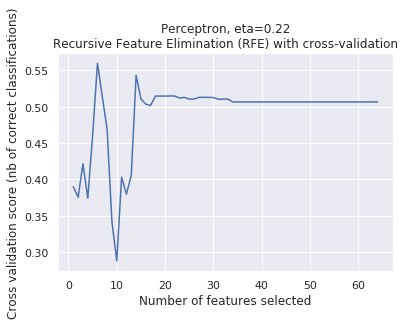

RFE fit, took, 98.73 seconds (1.65 minutes)


In [106]:
eta = 0.22
model_name = "Perceptron, eta={0}".format(eta)
ppn = Perceptron(max_iter=100, eta0=eta, random_state=1)
fit_rfecv(ppn, X, y, model_name)

Perceptron, eta=0.22 fit using RFE
Optimal number of features : 1


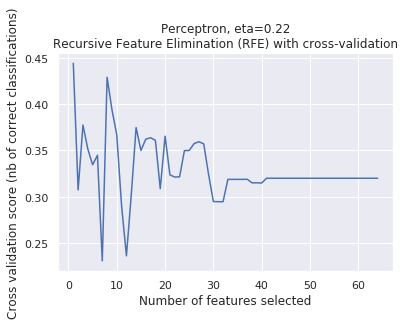

RFE fit, took, 300.43 seconds (5.01 minutes)


In [292]:
eta = 0.22
model_name = "Perceptron, eta={0}".format(eta)
ppn = Perceptron(max_iter=100, eta0=eta, random_state=1)
fit_rfecv(ppn, X, y, model_name, kfold=5)

### RFE with Decision Tree

Decision Tree (raw features, gini criterion, max_depth=16) fit using RFE
Optimal number of features : 40


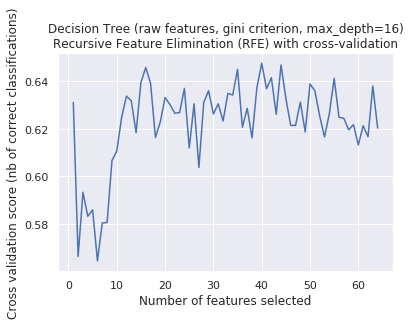

RFE fit, took, 177.45 seconds (2.96 minutes)


In [107]:
max_depth = 16
criterion = 'gini'
model_name = 'Decision Tree (raw features, {0} criterion, max_depth={1})'.format(criterion, max_depth)
tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=1)
fit_rfecv(tree, X, y, model_name)

Decision Tree (raw features, gini criterion, max_depth=16) fit using RFE
Optimal number of features : 28


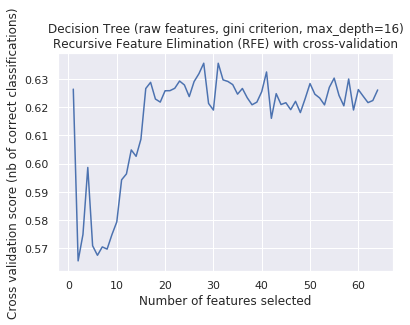

RFE fit, took, 550.78 seconds (9.18 minutes)


In [293]:
max_depth = 16
criterion = 'gini'
model_name = 'Decision Tree (raw features, {0} criterion, max_depth={1})'.format(criterion, max_depth)
tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=1)
fit_rfecv(tree, X, y, model_name, kfold=5)

### RFE with Random Forest

Random Forest (raw features, gini criterion, n_estimators=16) fit using RFE
Optimal number of features : 47


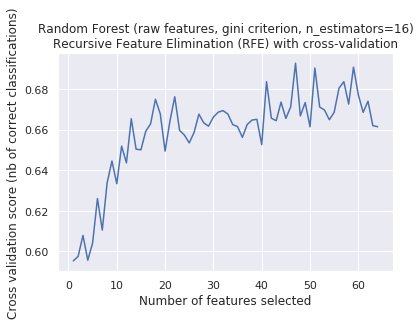

RFE fit, took, 137.90 seconds (2.30 minutes)


In [108]:
n_trees = 16
criterion = 'gini'
model_name = 'Random Forest (raw features, {0} criterion, n_estimators={1})'.format(criterion, n_trees)
forest = RandomForestClassifier(criterion=criterion, n_estimators=n_trees, random_state=1, n_jobs=8)
fit_rfecv(forest, X, y, model_name)

## Sequential Backwards Selection (SBS) algorithm

### SBS with Perceptron

Sequential Backwards Selection algorithm was applied. Took 644.87 seconds, (10.75 minutes).


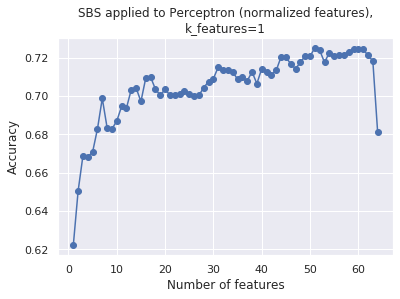

In [109]:
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
k_features = 1
model_name = "Perceptron (normalized features)"
save_name = 'ppn'
ppn_feats = fit_sbs(ppn, k_features, X_train_norm, y_train, output='save', 
            save_path='../../results/plots/sbs_all_{0}_kfeats_{1}.png'.format(save_name, k_features),
            title="SBS applied to {0},\nk_features={1}".format(model_name, k_features))

#### 19 best features

In [167]:
k = 19
sbs_ppn_k = feat_cols[list(ppn_feats[-k])]
sbs_ppn_k

Index(['xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'pin_years_since_last_sale', 'xy_years_since_last_sale',
       'da_days_since_last_sale', 'xy_sale_next_6m', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'price_da_pct_change', 'outlier_y_3', 'Avg_HHinc',
       'Pop_x', 'PopDens', 'Sgl_det', 'Owned', 'Walk', 'Lbrfrc', 'Jobs'],
      dtype='object')

In [168]:
subset_name = 'sbs_ppn'
sel_feats_df = pd.DataFrame(sbs_ppn_k).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    45
True     19
Name: sbs_ppn, dtype: int64

### SBS with Decision Tree

Sequential Backwards Selection algorithm was applied. Took 2,919.89 seconds, (48.66 minutes).


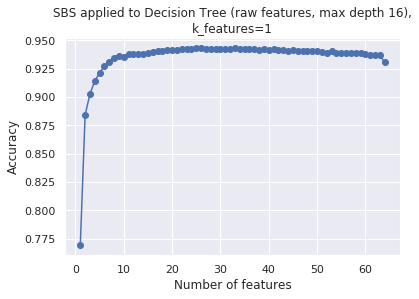

In [113]:
max_depth = 16
k_features = 1
tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=1)
model_name = 'Decision Tree (raw features, max depth {0})'.format(max_depth)
save_name = 'tree{0}'.format(max_depth)
tree_feats = fit_sbs(tree, k_features, X_train, y_train, output='save', 
                     save_path='../../results/plots/sbs_all_{0}_kfeats_{1}.png'.format(save_name, k_features),
                     title="SBS applied to {0},\nk_features={1}".format(model_name, k_features))

#### 19 best features

In [169]:
k = 19
sbs_tree_k = feat_cols[list(tree_feats[-k])]
sbs_tree_k

Index(['xy_prev_sales', 'xy_years_since_last_sale', 'xy_price_cum_sum',
       'med_price_xy', 'price_to_med_year', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'PopDens', 'Dwel', 'Sgl_det', 'Sgl_att',
       'Self_emp', 'Blue_cljob', 'White_cljob', 'FT_wrk', 'Stu', 'Jobs'],
      dtype='object')

In [170]:
subset_name = 'sbs_tree'
sel_feats_df = pd.DataFrame(sbs_tree_k).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    45
True     19
Name: sbs_tree, dtype: int64

### SBS with Random Forest

Sequential Backwards Selection algorithm was applied. Took 2,659.42 seconds, (44.32 minutes).


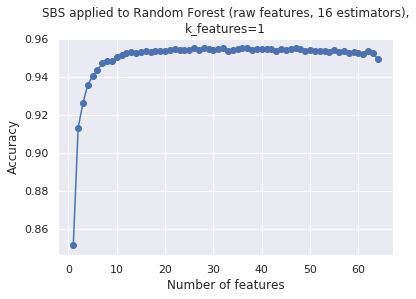

In [115]:
k_features = 1
n_trees = 16
forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=8)
model_name = 'Random Forest (raw features, {0} estimators)'.format(n_trees)
save_name = 'forest{0}'.format(n_trees)
rf_feats = fit_sbs(forest, k_features, X_train, y_train, output='save', 
                   save_path='../../results/plots/sbs_all_{0}_kfeats_{1}.png'.format(save_name, k_features),
                   title="SBS applied to {0},\nk_features={1}".format(model_name, k_features))

#### 19 best features

In [172]:
k = 19
sbs_forest_k = feat_cols[list(rf_feats[-k])]
sbs_forest_k

Index(['xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'pin_years_since_last_sale', 'price_da_pct_change', 'med_price_xy',
       'price_to_med_year', 'outlier_y_5', 'Sgl_det', 'Sgl_att', 'Rented',
       'PT', 'Unemp', 'Not_lbrfrc', 'Usl_wkpl', 'Pop_y', 'Stu', 'HH', 'Cars'],
      dtype='object')

In [173]:
subset_name = 'sbs_forest'
sel_feats_df = pd.DataFrame(sbs_forest_k).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    45
True     19
Name: sbs_forest, dtype: int64

## Summarize feature importance

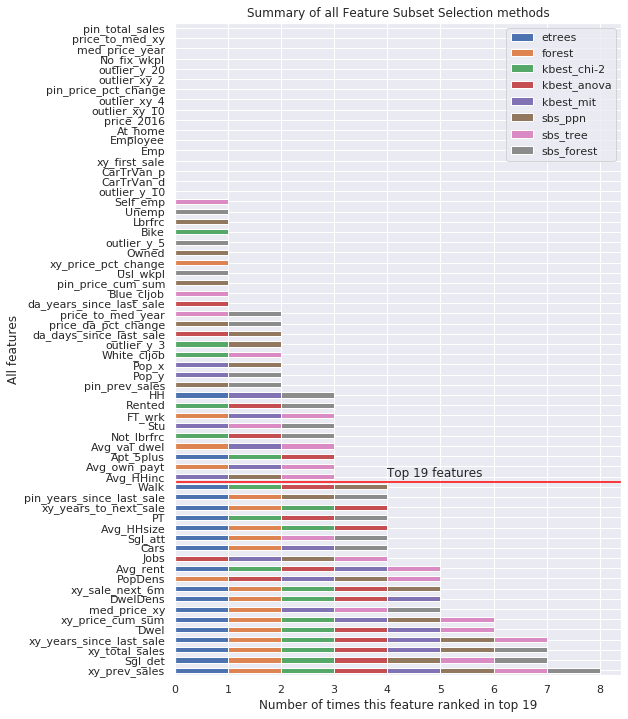

In [289]:
highlight_top = 19

feat_df = feat_df.set_index('var')
idx_order = feat_df.sum(axis=1).sort_values(ascending=False).index

f, ax = plt.subplots(1, figsize=(8, 12))

feat_df.loc[idx_order].astype('int').plot(kind='barh', stacked=True, ax=ax)

ax.set_title("Summary of all Feature Subset Selection methods")
ax.set_ylabel("All features")
ax.set_xlabel("Number of times this feature ranked in top {0}".format(highlight_top))
ax.axhline(highlight_top - 0.5, color='red')
ax.text(4, highlight_top, "Top {0} features".format(highlight_top))
plt.savefig('../../results/plots/all_features_selection_summary.png', dpi=300)

## Top selected features

In [279]:
min_selections = 4
mask1 = feat_df.sum(axis=1) >= 4
top_feats = feat_cols[mask1]
print("{0} features that were selected by at least {1} different methods:\n".format(len(top_feats), min_selections))
top_feats

19 features that were selected by at least 4 different methods:



Index(['xy_total_sales', 'xy_prev_sales', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'xy_sale_next_6m',
       'xy_price_cum_sum', 'med_price_xy', 'Avg_HHsize', 'Avg_rent', 'PopDens',
       'Dwel', 'DwelDens', 'Sgl_det', 'Sgl_att', 'PT', 'Walk', 'Jobs', 'Cars'],
      dtype='object')

In [280]:
top19f = ['xy_total_sales', 'xy_prev_sales', 'pin_years_since_last_sale',
          'xy_years_since_last_sale', 'xy_years_to_next_sale', 'xy_sale_next_6m',
          'xy_price_cum_sum', 'med_price_xy', 'Avg_HHsize', 'Avg_rent', 'PopDens',
          'Dwel', 'DwelDens', 'Sgl_det', 'Sgl_att', 'PT', 'Walk', 'Jobs', 'Cars']

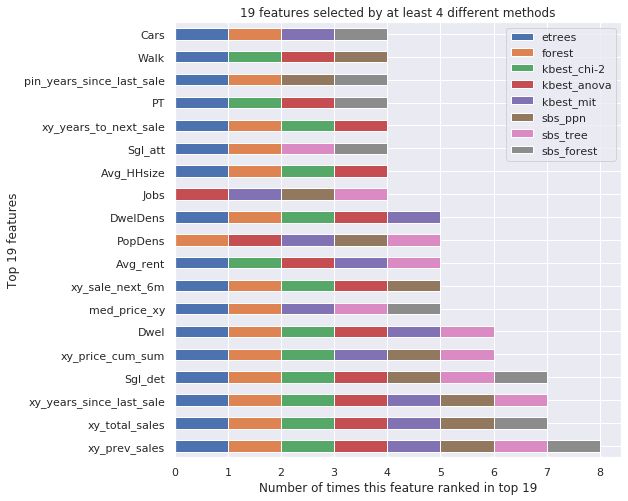

In [286]:
idx_order = feat_df.loc[top19f].sum(axis=1).sort_values(ascending=False).index
f, ax = plt.subplots(1, figsize=(8, 8))

feat_df.loc[idx_order].astype('int').plot(kind='barh', stacked=True, ax=ax)

ax.set_title("{0} features selected by at least {1} different methods".format(len(top_feats), min_selections))
ax.set_ylabel("Top {0} features".format(len(top_feats)))
ax.set_xlabel("Number of times this feature ranked in top {0}".format(highlight_top))
plt.savefig('../../results/plots/feature_selection_summary.png', dpi=300)